In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, cv2, random, time, shutil, csv


plt.rcParams["figure.figsize"] = (10, 6)

sns.set_style("whitegrid")
pd.set_option("display.float_format", lambda x: "%.3f" % x)


from tensorflow import keras
import tensorflow as tf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras import regularizers
from tensorflow.keras.preprocessing.image import load_img
from tqdm import tqdm
from keras.utils import to_categorical
from tensorflow.keras.layers import (
    Activation,
    Dropout,
    Flatten,
    Dense,
    Conv2D,
    MaxPooling2D,
    BatchNormalization
)


from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import RocCurveDisplay,accuracy_score, f1_score, recall_score,\
                            precision_score, make_scorer,\
                            classification_report,confusion_matrix,\
                            ConfusionMatrixDisplay, average_precision_score,\
                            roc_curve, roc_auc_score, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, MultiLabelBinarizer
from sklearn.utils.class_weight import compute_class_weight
#from scikitplot.metrics import plot_roc, precision_recall_curve,average_precision_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import label_binarize
import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

pd.set_option("display.max_columns", None)

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")


Mounted at /content/gdrive


In [ ]:
!unzip "/content/gdrive/MyDrive/dataset_pbl/train2.zip"

Streaming output truncated to the last 5000 lines.
  inflating: train/83bc62b0fffa99a9c94ba0b67a5f7395.jpg  
  inflating: train/83bcff6b55ee179a7c123fa6103c377a.jpg  
  inflating: train/83be6d622ab74a5e7e08b53eb8fd566a.jpg  
  inflating: train/83c2d7419b0429b9fe953bc1b6cddbec.jpg  
  inflating: train/83cf7d7cd2a759a93e2ffd95bea9c6fb.jpg  
  inflating: train/83d405858f0931722ef21e8ac0adee4d.jpg  
  inflating: train/83d4125a4c3c7dc5956563276cb1cd74.jpg  
  inflating: train/83f0bb565b2186dbcc6a9d009cb26ff2.jpg  
  inflating: train/83fad0718581a696132c96c166472627.jpg  
  inflating: train/83fbbcc9a612e3f712b1ba199da61f20.jpg  
  inflating: train/8403d8936430c2f05ab7d74d23c2c0cb.jpg  
  inflating: train/8406d837b2d7fac1c3cd621abb4c4f9e.jpg  
  inflating: train/840b67d26e5e43f8eb6430f62d4ba1ac.jpg  
  inflating: train/840db91ba4600148f3dcb06ec419b421.jpg  
  inflating: train/840dbad5a691c22611d85b2488bf4cbb.jpg  
  inflating: train/8410ced9ebc1759a7ebce5c42bfb5222.jpg  
  inflating: train/84

In [ ]:
labels_csv = pd.read_csv("/content/labels.csv")
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     fff43b07992508bc822f33d8ffd902ae  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


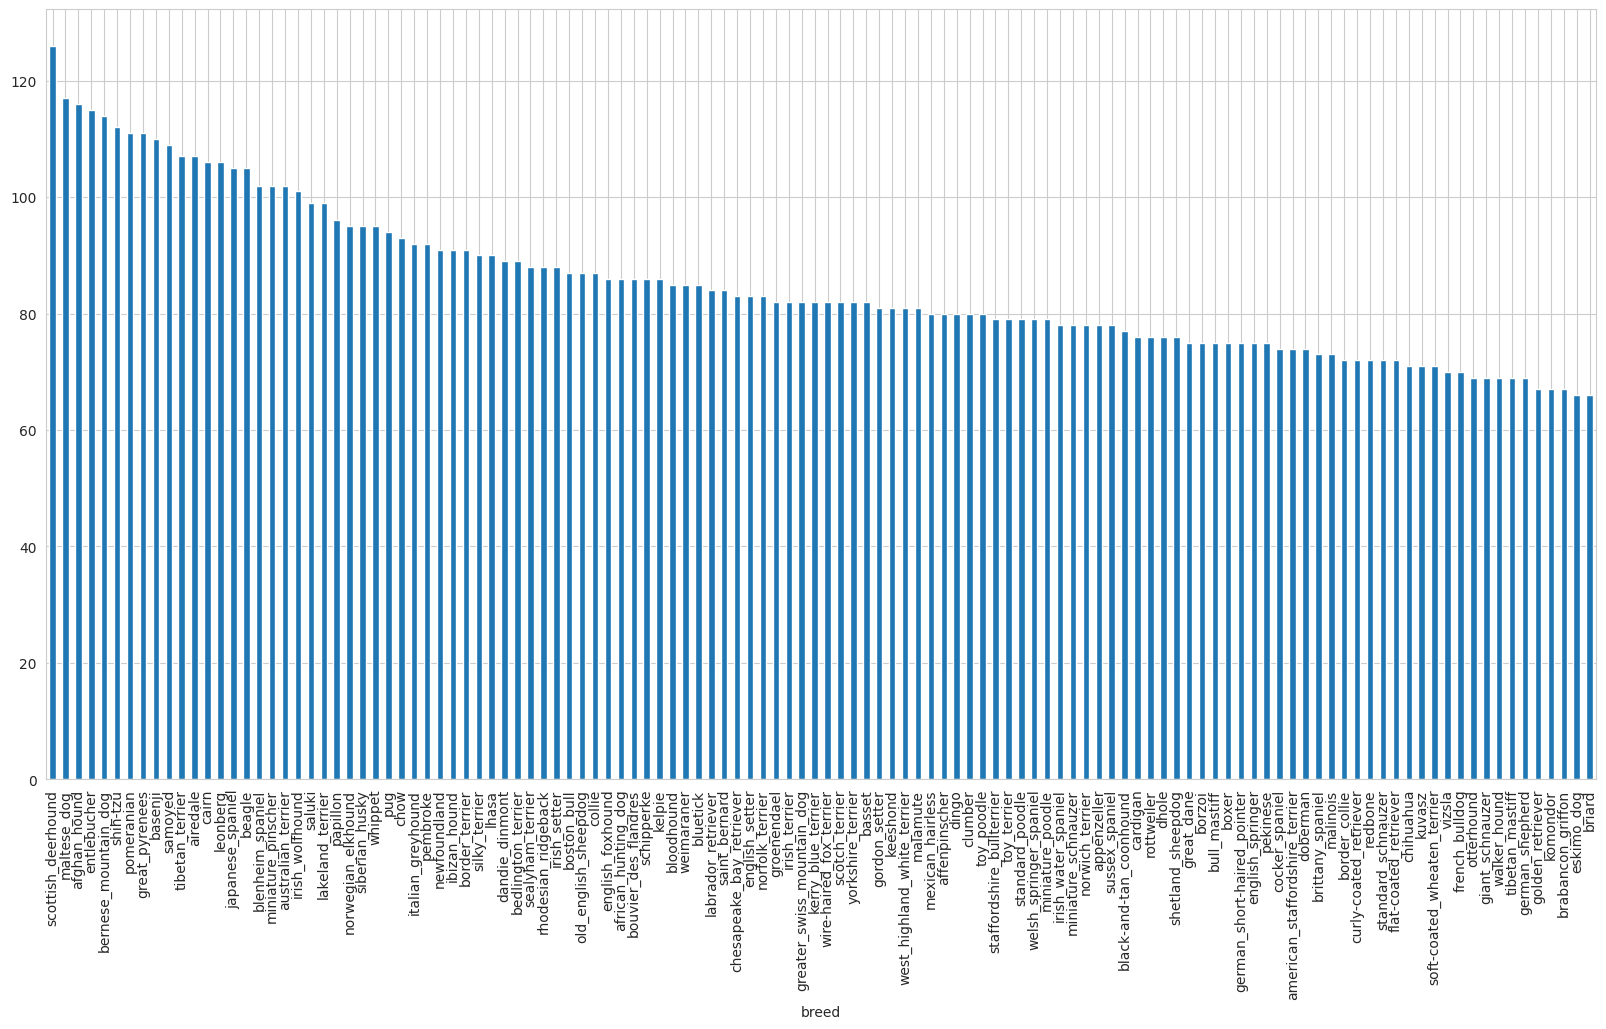

In [ ]:
labels_csv["breed"].value_counts().plot.bar(figsize=(20, 10));

In [ ]:
train_path = "/content/train/"

In [ ]:
filenames = [train_path + fname + ".jpg" for fname in labels_csv["id"]]
filenames[:10]

['/content/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 '/content/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 '/content/train/001cdf01b096e06d78e9e5112d419397.jpg',
 '/content/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 '/content/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 '/content/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 '/content/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 '/content/train/002a283a315af96eaea0e28e7163b21b.jpg',
 '/content/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 '/content/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

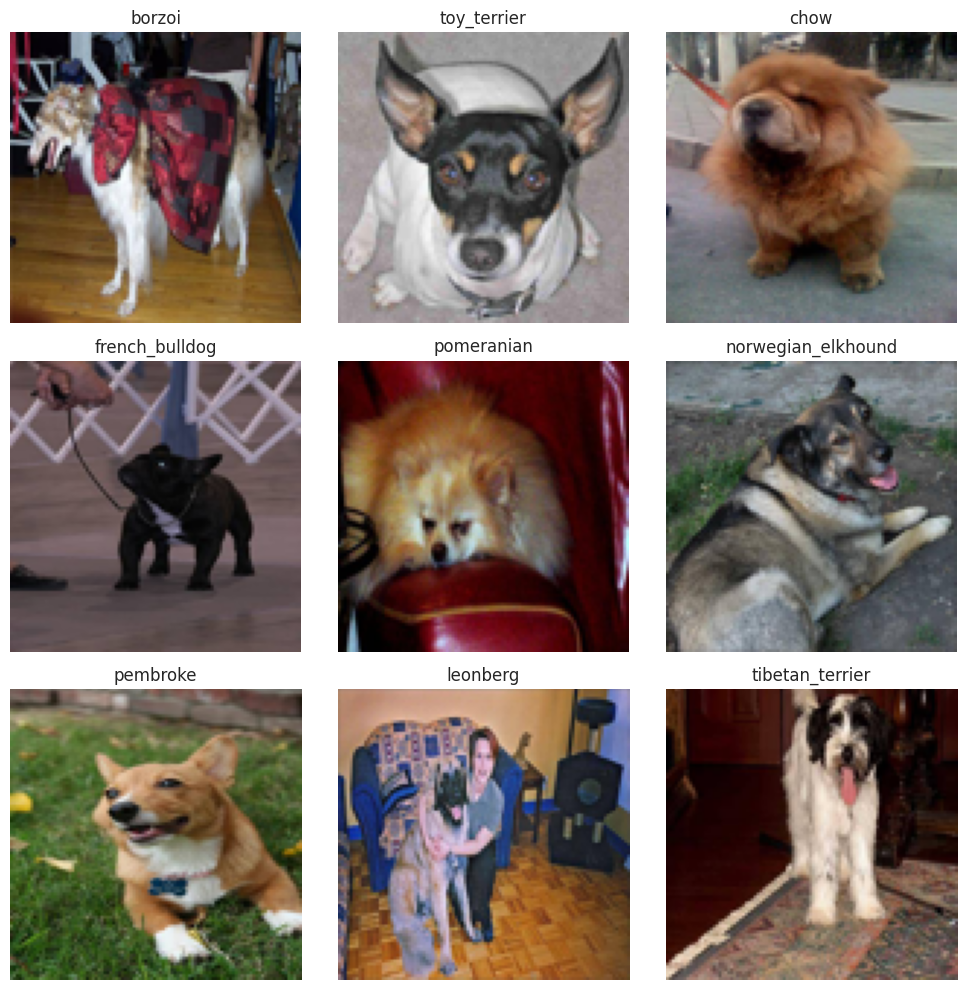

In [ ]:
from PIL import Image
import random
random_images = random.sample(filenames, 9)
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    img_path = random_images[i]
    img = Image.open(img_path)
    label = labels_csv[labels_csv["id"] == os.path.splitext(os.path.basename(img_path))[0]]["breed"].values[0]

    img = img.resize((100, 100))
    ax.imshow(img)
    ax.set_title(label)
    ax.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
labels = labels_csv["breed"].to_numpy() # convert labels column to NumPy array
labels[:20]

array(['boston_bull', 'dingo', 'pekinese', 'bluetick', 'golden_retriever',
       'bedlington_terrier', 'bedlington_terrier', 'borzoi', 'basenji',
       'scottish_deerhound', 'shetland_sheepdog', 'walker_hound',
       'maltese_dog', 'bluetick', 'norfolk_terrier',
       'african_hunting_dog', 'wire-haired_fox_terrier', 'redbone',
       'lakeland_terrier', 'boxer'], dtype=object)

In [ ]:
# See if number of labels matches the number of filenames
if len(labels) == len(filenames):
  print("Number of labels matches number of filenames!")
else:
  print("Number of labels does not match number of filenames, check data directories.")

Number of labels matches number of filenames!


In [ ]:
# Find the unique label values
unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [ ]:
# Turn every label into a boolean array
boolean_labels = [label == np.array(unique_breeds) for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [ ]:
# Example: Turning a boolean array into integers
print(labels[1]) # original label
print(np.where(unique_breeds == labels[1])[0][0]) # index where label occurs
print(boolean_labels[1].argmax()) # index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # there will be a 1 where the sample label occurs

dingo
37
37
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [ ]:
# Setup X & y variables
X = filenames
y = boolean_labels

print(f"Number of training images: {len(X)}")
print(f"Number of labels: {len(y)}")

Number of training images: 10222
Number of labels: 10222


In [ ]:
import pandas as pd

# Setup X & y variables
X = filenames
y = [np.where(label)[0][0] for label in boolean_labels]

# Create a DataFrame
train_df = pd.DataFrame({'image': X, 'label': y})

# Display the DataFrame
train_df.sample(10)


,image,label
2846,/content/train/46135053e19800f8af958fb32ef11db...,9
7012,/content/train/afcd1d553c48f0d434b873920dd6d4a...,80
8407,/content/train/d2fb39916010a712b342631075981c2...,47
7073,/content/train/b18a0f00efc8c6e741bf392c4fc34a2...,29
6473,/content/train/a300b9437a786533fbac5331bcb6996...,101
5418,/content/train/88a9c4a74b1663c9b30ab62e3573ee7...,93
120,/content/train/02dfcd0a24a9c41070f4f94b4c9933f...,57
7017,/content/train/aff9e4c944e3e7b24b8166590d7ca95...,20
4181,/content/train/680930cbada27fa117d6e1670d218d9...,76
751,/content/train/12b72be0bcd7a96172fee4f7cd5b01f...,52


In [ ]:
list(train_df.iloc[1])

['/content/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg', 37]

In [ ]:
refactor_size = 64
resized_image_list = []
all_paths = []

# Loop through the DataFrame to load and process images
for i in range(len(train_df)):
    image_path = train_df.iloc[i]['image']
    label = train_df.iloc[i]['label']

    # Load and process the image
    img = tf.keras.utils.load_img(image_path, target_size=(refactor_size, refactor_size))
    img_vals = tf.image.convert_image_dtype(img, tf.float32)
    imgarr = tf.keras.utils.img_to_array(img_vals)

    # Append the processed image and label to the lists
    resized_image_list.append(imgarr)
    all_paths.append(image_path)

# Convert the lists to numpy arrays
resized_image_list = np.asarray(resized_image_list)

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print("Available GPUs:", gpus)

Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


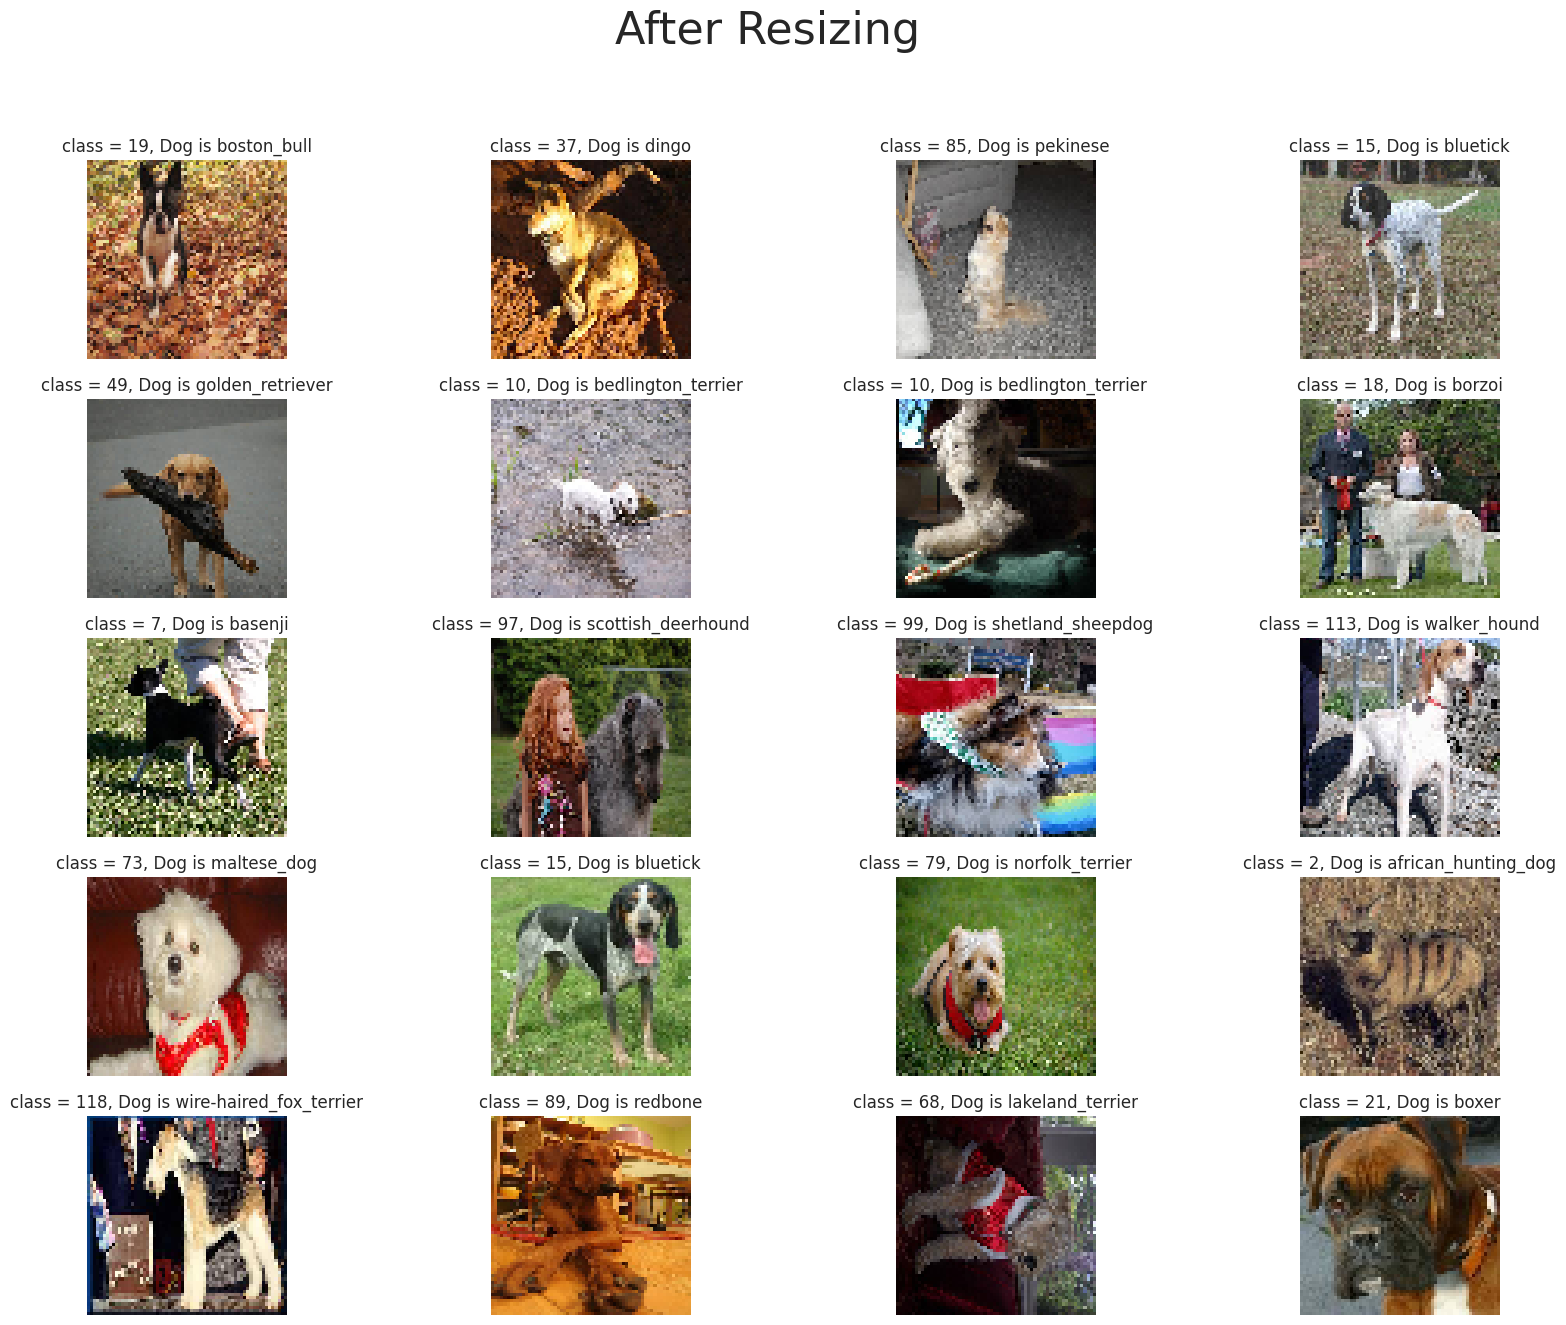

In [ ]:
nrow = 5
ncol = 4
fig1 = plt.figure(figsize=(20, 15))
fig1.suptitle('After Resizing', size=32)

for i in range(min(20, len(resized_image_list))):
    plt.subplot(nrow, ncol, i + 1)
    plt.imshow(resized_image_list[i])
    plt.title('class = {x}, Dog is {y}'.format(x=train_df["label"].iloc[i], y=labels[i]))
    plt.axis('Off')
    plt.grid(False)
plt.show()

![image.png](https://www.baeldung.com/wp-content/uploads/sites/4/2022/08/AugmentData.png)
[Credit](https://www.google.com/url?sa=i&url=https%3A%2F%2Fwww.baeldung.com%2Fcs%2Fml-data-augmentation&psig=AOvVaw09snYZgTuBqA-qUMBKYYYj&ust=1701605614028000&source=images&cd=vfe&opi=89978449&ved=0CBEQjRxqFwoTCJDYxYPd8IIDFQAAAAAdAAAAABBG)

In [ ]:
from tensorflow.keras import layers

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.3),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.5)
], name='data_augmentation')

In [ ]:
augmented_images = data_augmentation(resized_image_list)

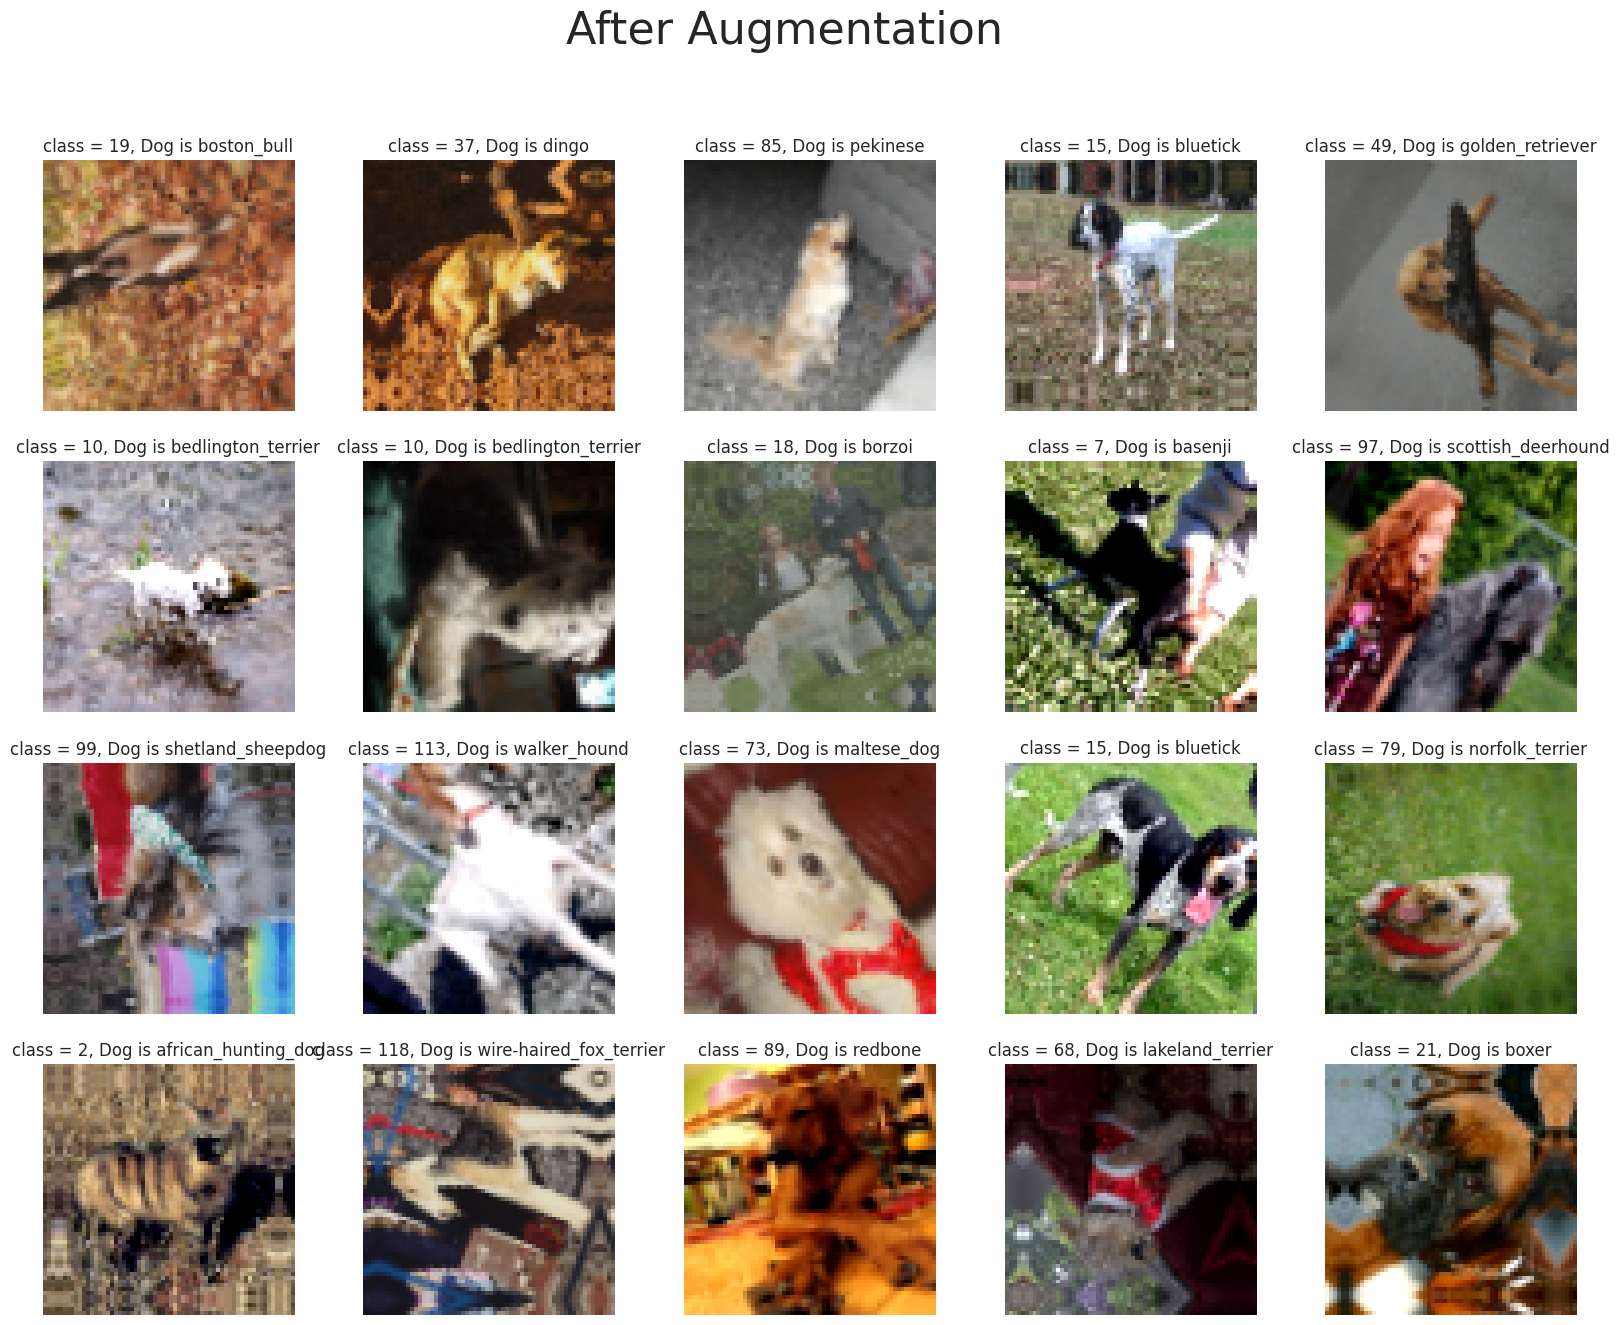

In [ ]:
nrow = 4
ncol = 5

augmented_indices = range(min(20, len(resized_image_list)))

fig2 = plt.figure(figsize=(20, 15))
fig2.suptitle('After Augmentation', size=32)

for i, idx in enumerate(augmented_indices):
    augmented_image = data_augmentation(tf.expand_dims(resized_image_list[idx], 0), training=True)
    plt.subplot(nrow, ncol, i + 1)
    plt.imshow(augmented_image[0].numpy())
    plt.title('class = {x}, Dog is {y}'.format(x=train_df["label"].iloc[idx], y=labels[idx]))
    plt.axis('Off')
    plt.grid(False)

plt.show()

In [ ]:
class_values = train_df["label"]
filtered_values = class_values[class_values < 0]

if not filtered_values.empty:
    print("There are values in the series less than 0.")
else:
    print("There are no values in the series less than 0.")
class_values.value_counts()

There are no values in the series less than 0.


label
97    126
73    117
1     116
42    115
11    114
     ... 
49     67
65     67
22     67
43     66
23     66
Name: count, Length: 120, dtype: int64

In [ ]:
# Assuming you have NumPy arrays for augmented_images and selected_labels
# Convert NumPy arrays to TensorFlow tensors
augmented_images_tf = tf.convert_to_tensor(augmented_images)
selected_labels_tf = tf.convert_to_tensor(train_df['label'])

# Convert TensorFlow tensors back to NumPy arrays
augmented_images_np = augmented_images_tf.numpy()
selected_labels_np = selected_labels_tf.numpy()

# Split them into training and validation using NUM_IMAGES
X_train, X_test, y_train, y_test = train_test_split(
    augmented_images_np,
    selected_labels_np,
    test_size=0.1,
    stratify = selected_labels_np,
    random_state=42
)

# X_train, X_val, y_train, y_val = train_test_split(
#     X_train,
#     y_train,
#     test_size=0.1,  # You can adjust the validation split as needed
#     stratify = y_train,
#     random_state=42
# )

print("Training Set Length:", len(X_train))
print("Test Set Length:", len(X_test))
# print("Validation Set Length:", len(X_val))

Training Set Length: 9199
Test Set Length: 1023


In [ ]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

class_weights = compute_class_weight('balanced', classes=np.unique(y_train_encoded), y=y_train_encoded)


class_weights_dict = {class_num: weight for class_num, weight in zip(np.unique(y_train_encoded), class_weights)}

print("Class Weights Dictionary:")
print(class_weights_dict)

Class Weights Dictionary:
{0: 1.064699074074074, 1: 0.737099358974359, 2: 0.9955627705627705, 3: 0.7985243055555555, 4: 1.1441542288557214, 5: 1.0951190476190475, 6: 0.8332427536231884, 7: 0.7743265993265993, 8: 1.0359234234234234, 9: 0.8155141843971632, 10: 0.9582291666666667, 11: 0.7442556634304207, 12: 1.1109903381642512, 13: 0.8332427536231884, 14: 0.9955627705627705, 15: 0.9955627705627705, 16: 1.1793589743589743, 17: 0.9348577235772357, 18: 1.1273284313725491, 19: 0.9827991452991452, 20: 0.9955627705627705, 21: 1.1273284313725491, 22: 1.277638888888889, 23: 1.2992937853107345, 24: 1.161489898989899, 25: 1.1273284313725491, 26: 0.8069298245614035, 27: 1.1273284313725491, 28: 1.0221111111111112, 29: 1.1977864583333333, 30: 0.9125992063492063, 31: 1.064699074074074, 32: 1.1441542288557214, 33: 0.9827991452991452, 34: 1.1793589743589743, 35: 0.9582291666666667, 36: 1.1273284313725491, 37: 1.064699074074074, 38: 1.1441542288557214, 39: 0.9955627705627705, 40: 1.0221111111111112, 41: 1

In [ ]:
X_train.shape

(9199, 64, 64, 3)

In [ ]:
# model structure

In [ ]:
model = Sequential()

model.add(Conv2D(64, (3, 3), activation="relu", input_shape=X_train.shape[1:], padding = 'same'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation="relu", padding = 'same'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(256, (3, 3), activation="relu", padding = 'same'))
model.add(MaxPooling2D((2, 2)))


model.add(Flatten())

model.add(Dense(60, activation="relu"))

model.add(Dense(80, activation="relu"))

model.add(Dense(120, activation="softmax"))

model.compile(optimizer="adam",
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 256)       295168    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 8, 8, 256)         0

In [ ]:
#Prepare call backs
EarlyStop_callback = EarlyStopping(monitor='val_loss',mode = 'min', verbose = 1, patience=15, restore_best_weights=True)
my_callback=[EarlyStop_callback]

In [ ]:
model.fit(X_train, y_train, validation_data=(X_test, y_test),
          epochs=100, #validation_split = 0.1,
          batch_size = 128, callbacks=my_callback, class_weight = class_weights_dict)

Epoch 1/100
72/72 [==============================] - 12s 77ms/step - loss: 4.7889 - accuracy: 0.0045 - val_loss: 4.7875 - val_accuracy: 0.0078
Epoch 2/100
72/72 [==============================] - 2s 34ms/step - loss: 4.7880 - accuracy: 0.0077 - val_loss: 4.7875 - val_accuracy: 0.0098
Epoch 3/100
72/72 [==============================] - 2s 32ms/step - loss: 4.7879 - accuracy: 0.0040 - val_loss: 4.7875 - val_accuracy: 0.0078
Epoch 4/100
72/72 [==============================] - 2s 32ms/step - loss: 4.7879 - accuracy: 0.0059 - val_loss: 4.7875 - val_accuracy: 0.0108
Epoch 5/100
72/72 [==============================] - 2s 32ms/step - loss: 4.7878 - accuracy: 0.0087 - val_loss: 4.7875 - val_accuracy: 0.0117
Epoch 6/100
72/72 [==============================] - 2s 34ms/step - loss: 4.7879 - accuracy: 0.0063 - val_loss: 4.7875 - val_accuracy: 0.0068
Epoch 7/100
72/72 [==============================] - 3s 36ms/step - loss: 4.7879 - accuracy: 0.0051 - val_loss: 4.7875 - val_accuracy: 0.0078
Epoch

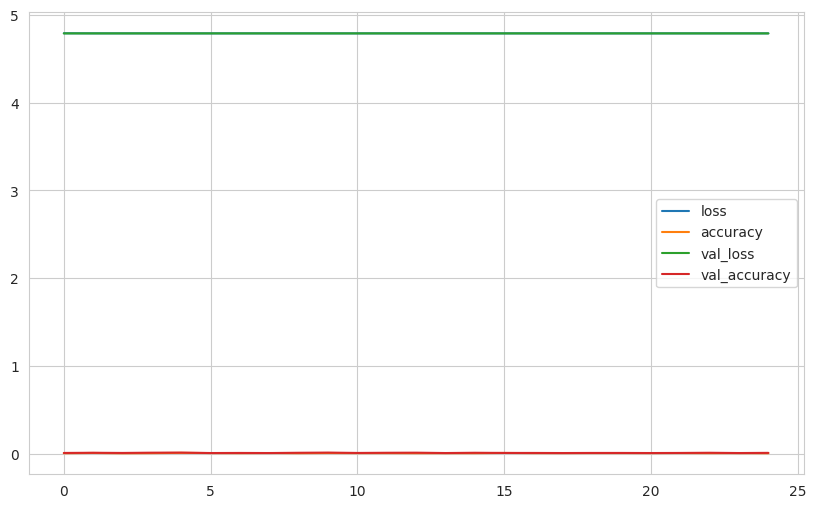

In [ ]:
pd.DataFrame(model.history.history).plot()
plt.show()

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print("loss: ", loss)
print("accuracy: ", accuracy)

loss:  4.787397861480713
accuracy:  0.01173020526766777


In [ ]:
model_2 = Sequential()

model_2.add(Conv2D(64, (3, 3), activation="relu", input_shape=X_train.shape[1:], padding = 'same'))
model_2.add(MaxPooling2D((2, 2)))

model_2.add(Conv2D(128, (3, 3), activation="relu", padding = 'same'))
model_2.add(MaxPooling2D((2, 2)))

model_2.add(Conv2D(256, (3, 3), activation="relu", padding = 'same'))

model_2.add(MaxPooling2D((2, 2)))
model_2.add(Flatten())

model_2.add(Dense(60, activation="relu"))

model_2.add(Dense(80, activation="relu"))

model_2.add(Dense(120, activation="softmax"))

model_2.compile(optimizer="adam",
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 32, 32, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 16, 16, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 256)       295168    
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 8, 8, 256)        

In [ ]:
#Prepare call backs
EarlyStop_callback = EarlyStopping(monitor='val_loss',mode = 'min', verbose = 1, patience=15, restore_best_weights=True)
my_callback=[EarlyStop_callback]

In [ ]:
model_2.fit(X_train, y_train, validation_data=(X_test, y_test),
          epochs=400, #validation_split = 0.1,
          batch_size = 128, callbacks=my_callback, class_weight = class_weights_dict)

Epoch 1/400
72/72 [==============================] - 4s 40ms/step - loss: 4.7888 - accuracy: 0.0072 - val_loss: 4.7876 - val_accuracy: 0.0088
Epoch 2/400
72/72 [==============================] - 3s 36ms/step - loss: 4.7879 - accuracy: 0.0054 - val_loss: 4.7875 - val_accuracy: 0.0088
Epoch 3/400
72/72 [==============================] - 3s 42ms/step - loss: 4.7879 - accuracy: 0.0063 - val_loss: 4.7875 - val_accuracy: 0.0088
Epoch 4/400
72/72 [==============================] - 3s 35ms/step - loss: 4.7879 - accuracy: 0.0061 - val_loss: 4.7875 - val_accuracy: 0.0088
Epoch 5/400
72/72 [==============================] - 2s 32ms/step - loss: 4.7879 - accuracy: 0.0057 - val_loss: 4.7875 - val_accuracy: 0.0068
Epoch 6/400
72/72 [==============================] - 2s 32ms/step - loss: 4.7879 - accuracy: 0.0049 - val_loss: 4.7875 - val_accuracy: 0.0068
Epoch 7/400
72/72 [==============================] - 2s 33ms/step - loss: 4.7879 - accuracy: 0.0057 - val_loss: 4.7875 - val_accuracy: 0.0068
Epoch 

In [ ]:
loss, accuracy = model_2.evaluate(X_test, y_test, verbose=0)
print("loss: ", loss)
print("accuracy: ", accuracy)

loss:  4.787420272827148
accuracy:  0.009775171056389809


In [ ]:
model_3 = Sequential()

model_3.add(Conv2D(64, (3, 3), activation="relu", input_shape=X_train.shape[1:], padding = 'same'))
model_3.add(MaxPooling2D((2, 2)))

model_3.add(Conv2D(128, (3, 3), activation="relu", padding = 'same'))
model_3.add(MaxPooling2D((2, 2)))

model_3.add(Conv2D(256, (3, 3), activation="relu", padding = 'same'))
model_3.add(MaxPooling2D((2, 2)))

model_3.add(Conv2D(128, (3, 3), activation="relu"))#new layer
model_3.add(MaxPooling2D((2, 2)))
model_3.add(Flatten())

model_3.add(Dense(60, activation="relu"))

model_3.add(Dense(80, activation="relu"))

model_3.add(Dense(120, activation="softmax"))

model_3.compile(optimizer="adam",
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 32, 32, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 16, 16, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 16, 16, 256)       295168    
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 8, 8, 256)        

In [ ]:
model_3.fit(X_train, y_train, validation_data=(X_test, y_test),
          epochs=400, #validation_split = 0.1,
          batch_size = 128, callbacks=my_callback, class_weight = class_weights_dict)

Epoch 1/400
72/72 [==============================] - 5s 42ms/step - loss: 4.7889 - accuracy: 0.0067 - val_loss: 4.7875 - val_accuracy: 0.0078
Epoch 2/400
72/72 [==============================] - 3s 35ms/step - loss: 4.7880 - accuracy: 0.0064 - val_loss: 4.7875 - val_accuracy: 0.0068
Epoch 3/400
72/72 [==============================] - 3s 40ms/step - loss: 4.7879 - accuracy: 0.0050 - val_loss: 4.7875 - val_accuracy: 0.0068
Epoch 4/400
72/72 [==============================] - 3s 41ms/step - loss: 4.7831 - accuracy: 0.0073 - val_loss: 4.7744 - val_accuracy: 0.0098
Epoch 5/400
72/72 [==============================] - 3s 45ms/step - loss: 4.7190 - accuracy: 0.0107 - val_loss: 4.6757 - val_accuracy: 0.0127
Epoch 6/400
72/72 [==============================] - 3s 36ms/step - loss: 4.6423 - accuracy: 0.0137 - val_loss: 4.6383 - val_accuracy: 0.0147
Epoch 7/400
72/72 [==============================] - 3s 36ms/step - loss: 4.6084 - accuracy: 0.0170 - val_loss: 4.6248 - val_accuracy: 0.0205
Epoch 

In [ ]:
loss, accuracy = model_3.evaluate(X_test, y_test, verbose=0)
print("loss: ", loss)
print("accuracy: ", accuracy)

loss:  4.349587440490723
accuracy:  0.04496578872203827


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Create a Sequential model
alexnet_model = Sequential()

# First convolutional layer
alexnet_model.add(Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=X_train.shape[1:], padding='valid'))

# Max pooling
alexnet_model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid'))

# Second convolutional layer
alexnet_model.add(Conv2D(256, (5, 5), strides=(1, 1), activation='relu', padding='same'))

# Max pooling
alexnet_model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid'))

# Third convolutional layer
alexnet_model.add(Conv2D(384, (3, 3), strides=(1, 1), activation='relu', padding='same'))

# Fourth convolutional layer
alexnet_model.add(Conv2D(384, (3, 3), strides=(1, 1), activation='relu', padding='same'))

# Fifth convolutional layer
alexnet_model.add(Conv2D(256, (3, 3), strides=(1, 1), activation='relu', padding='same'))

# Max pooling
alexnet_model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))

# Flatten the output of the convolutional layers
alexnet_model.add(Flatten())

# First fully connected layer
alexnet_model.add(Dense(4096, activation='relu'))

# Add dropout for regularization
alexnet_model.add(Dropout(0.5))

# Second fully connected layer
alexnet_model.add(Dense(4096, activation='relu'))

# Add dropout for regularization
alexnet_model.add(Dropout(0.5))

# Output layer
alexnet_model.add(Dense(120, activation='softmax'))

# Compile the model
alexnet_model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

# Print a summary of the model
alexnet_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 14, 14, 96)        34944     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 6, 6, 96)          0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 6, 6, 256)         614656    
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 2, 2, 256)         0         
 ng2D)                                                           
                                                                 
 conv2d_12 (Conv2D)          (None, 2, 2, 384)         885120    
                                                                 
 conv2d_13 (Conv2D)          (None, 2, 2, 384)        

In [ ]:
alexnet_model.fit(X_train, y_train, validation_data=(X_test, y_test),
          epochs=400, #validation_split = 0.1,
          batch_size = 128, callbacks=my_callback, class_weight = class_weights_dict)

Epoch 1/400
72/72 [==============================] - 12s 56ms/step - loss: 4.7908 - accuracy: 0.0058 - val_loss: 4.7875 - val_accuracy: 0.0068
Epoch 2/400
72/72 [==============================] - 2s 27ms/step - loss: 4.7885 - accuracy: 0.0061 - val_loss: 4.7874 - val_accuracy: 0.0088
Epoch 3/400
72/72 [==============================] - 2s 25ms/step - loss: 4.7882 - accuracy: 0.0072 - val_loss: 4.7875 - val_accuracy: 0.0068
Epoch 4/400
72/72 [==============================] - 2s 24ms/step - loss: 4.7881 - accuracy: 0.0062 - val_loss: 4.7876 - val_accuracy: 0.0088
Epoch 5/400
72/72 [==============================] - 2s 26ms/step - loss: 4.7879 - accuracy: 0.0057 - val_loss: 4.7876 - val_accuracy: 0.0068
Epoch 6/400
72/72 [==============================] - 2s 26ms/step - loss: 4.7880 - accuracy: 0.0046 - val_loss: 4.7876 - val_accuracy: 0.0068
Epoch 7/400
72/72 [==============================] - 2s 28ms/step - loss: 4.7879 - accuracy: 0.0062 - val_loss: 4.7875 - val_accuracy: 0.0078
Epoch

In [ ]:
loss, accuracy = alexnet_model.evaluate(X_test, y_test, verbose=0)
print("loss: ", loss)
print("accuracy: ", accuracy)

loss:  4.7874226570129395
accuracy:  0.008797653950750828


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Initialize a Sequential model
vgg16_model = Sequential()

# Add the layers sequentially
vgg16_model.add(Conv2D(64, (3, 3), activation="relu", input_shape=X_train.shape[1:], padding='same'))
vgg16_model.add(MaxPooling2D((2, 2)))

vgg16_model.add(Conv2D(128, (3, 3), activation="relu", padding='same'))
vgg16_model.add(MaxPooling2D((2, 2)))

vgg16_model.add(Conv2D(256, (3, 3), activation="relu", padding='same'))
vgg16_model.add(MaxPooling2D((2, 2)))

# New Convolutional Layer
vgg16_model.add(Conv2D(128, (3, 3), activation="relu"))  # new layer
vgg16_model.add(MaxPooling2D((2, 2)))

vgg16_model.add(Flatten())
vgg16_model.add(Dense(60, activation="relu"))
vgg16_model.add(Dense(80, activation="relu"))
vgg16_model.add(Dense(120, activation="softmax"))

# Compile the model
vgg16_model.compile(optimizer="adam",
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])
vgg16_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 32, 32, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 16, 16, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 16, 16, 256)       295168    
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 8, 8, 256)        

In [ ]:
vgg16_model.fit(X_train, y_train, validation_data=(X_test, y_test),
          epochs=400, #validation_split = 0.1,
          batch_size = 128, callbacks=my_callback, class_weight = class_weights_dict)

Epoch 1/400
72/72 [==============================] - 5s 40ms/step - loss: 4.7887 - accuracy: 0.0079 - val_loss: 4.7875 - val_accuracy: 0.0068
Epoch 2/400
72/72 [==============================] - 2s 35ms/step - loss: 4.7880 - accuracy: 0.0058 - val_loss: 4.7875 - val_accuracy: 0.0088
Epoch 3/400
72/72 [==============================] - 2s 34ms/step - loss: 4.7879 - accuracy: 0.0058 - val_loss: 4.7876 - val_accuracy: 0.0068
Epoch 4/400
72/72 [==============================] - 3s 38ms/step - loss: 4.7879 - accuracy: 0.0062 - val_loss: 4.7880 - val_accuracy: 0.0078
Epoch 5/400
72/72 [==============================] - 3s 40ms/step - loss: 4.7880 - accuracy: 0.0083 - val_loss: 4.7875 - val_accuracy: 0.0068
Epoch 6/400
72/72 [==============================] - 3s 39ms/step - loss: 4.7880 - accuracy: 0.0057 - val_loss: 4.7871 - val_accuracy: 0.0108
Epoch 7/400
72/72 [==============================] - 3s 36ms/step - loss: 4.7880 - accuracy: 0.0073 - val_loss: 4.7874 - val_accuracy: 0.0108
Epoch 

In [ ]:
loss, accuracy = vgg16_model.evaluate(X_test, y_test, verbose=0)
print("loss: ", loss)
print("accuracy: ", accuracy)

loss:  4.367560863494873
accuracy:  0.04692082107067108



<a id="vgg16"></a>
|
<div style="border-radius: 10px; border: 1px solid black; background-color:white ; font-size: 100%; text-align: left; box-shadow: 2px 2px 4px rgba(0, 0, 0, 0.5); padding: 10px; margin-bottom: 20px;">
    <h2 style="border: 0; border-radius: 15px; font-weight: bold; font-size: 220%; color: white; background-color: red; padding: 10px; text-align: center; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.5);">🌟 VGG16 Model 🌟</h2>
    <img src="https://media.geeksforgeeks.org/wp-content/uploads/20200219152207/new41.jpg" alt="VGG16 Architecture" style="width: 70%; display: block; margin: auto; border-radius: 10px; box-shadow: 2px 2px 4px rgba(0, 0, 0, 0.5);">
    <p>
        <strong style="color: black;">VGG16</strong> is a convolutional neural network (CNN) architecture designed by the Visual Graphics Group (VGG) at the University of Oxford. It was introduced by Simonyan and Zisserman in 2014. VGG16 is known for its simplicity and uniform architecture, featuring small-sized convolutional filters.
    </p>
    <p>
        <strong style="color: black;">Model Architecture:</strong> VGG16's architecture consists of 16 weight layers, including 13 convolutional layers and 3 fully connected layers. The convolutional layers use small 3x3 filters, and the max-pooling layers follow each group of convolutional layers. The architecture is straightforward and easy to understand.
    </p>
    <p>
        <strong style="color: black;">Training and Data:</strong> VGG16 is typically trained on large-scale visual datasets, with the ImageNet dataset being a common choice. The training process involves optimizing the network's weights to classify a diverse set of images across 1000 classes. The extensive data in ImageNet contributes to the model's ability to recognize various visual patterns.
    </p>
    <p>
        <strong style="color: black;">Applications:</strong> VGG16 is widely used for image classification tasks. Its architecture's simplicity and effectiveness make it a popular choice for various computer vision applications. Transfer learning with VGG16 is also common in projects with limited labeled data.
    </p>
</div>

Photo Credit: [GeeksforGeeks](https://www.geeksforgeeks.org/vgg-16-cnn-model/)

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

# Define your class labels dictionary
class_labels = {
    'affenpinscher': 0, 'afghan_hound': 1, 'african_hunting_dog': 2, 'airedale': 3, 'american_staffordshire_terrier': 4,
    'appenzeller': 5, 'australian_terrier': 6, 'basenji': 7, 'basset': 8, 'beagle': 9, 'bedlington_terrier': 10,
    'bernese_mountain_dog': 11, 'black-and-tan_coonhound': 12, 'blenheim_spaniel': 13, 'bloodhound': 14, 'bluetick': 15,
    'border_collie': 16, 'border_terrier': 17, 'borzoi': 18, 'boston_bull': 19, 'bouvier_des_flandres': 20, 'boxer': 21,
    'brabancon_griffon': 22, 'briard': 23, 'brittany_spaniel': 24, 'bull_mastiff': 25, 'cairn': 26, 'cardigan': 27,
    'chesapeake_bay_retriever': 28, 'chihuahua': 29, 'chow': 30, 'clumber': 31, 'cocker_spaniel': 32, 'collie': 33,
    'curly-coated_retriever': 34, 'dandie_dinmont': 35, 'dhole': 36, 'dingo': 37, 'doberman': 38, 'english_foxhound': 39,
    'english_setter': 40, 'english_springer': 41, 'entlebucher': 42, 'eskimo_dog': 43, 'flat-coated_retriever': 44,
    'french_bulldog': 45, 'german_shepherd': 46, 'german_short-haired_pointer': 47, 'giant_schnauzer': 48,
    'golden_retriever': 49, 'gordon_setter': 50, 'great_dane': 51, 'great_pyrenees': 52, 'greater_swiss_mountain_dog': 53,
    'groenendael': 54, 'ibizan_hound': 55, 'irish_setter': 56, 'irish_terrier': 57, 'irish_water_spaniel': 58,
    'irish_wolfhound': 59, 'italian_greyhound': 60, 'japanese_spaniel': 61, 'keeshond': 62, 'kelpie': 63,
    'kerry_blue_terrier': 64, 'komondor': 65, 'kuvasz': 66, 'labrador_retriever': 67, 'lakeland_terrier': 68,
    'leonberg': 69, 'lhasa': 70, 'malamute': 71, 'malinois': 72, 'maltese_dog': 73, 'mexican_hairless': 74,
    'miniature_pinscher': 75, 'miniature_poodle': 76, 'miniature_schnauzer': 77, 'newfoundland': 78,
    'norfolk_terrier': 79, 'norwegian_elkhound': 80, 'norwich_terrier': 81, 'old_english_sheepdog': 82,
    'otterhound': 83, 'papillon': 84, 'pekinese': 85, 'pembroke': 86, 'pomeranian': 87, 'pug': 88, 'redbone': 89,
    'rhodesian_ridgeback': 90, 'rottweiler': 91, 'saint_bernard': 92, 'saluki': 93, 'samoyed': 94, 'schipperke': 95,
    'scotch_terrier': 96, 'scottish_deerhound': 97, 'sealyham_terrier': 98, 'shetland_sheepdog': 99, 'shih-tzu': 100,
    'siberian_husky': 101, 'silky_terrier': 102, 'soft-coated_wheaten_terrier': 103, 'staffordshire_bullterrier': 104,
    'standard_poodle': 105, 'standard_schnauzer': 106, 'sussex_spaniel': 107, 'tibetan_mastiff': 108,
    'tibetan_terrier': 109, 'toy_poodle': 110, 'toy_terrier': 111, 'vizsla': 112, 'walker_hound': 113,
    'weimaraner': 114, 'welsh_springer_spaniel': 115, 'west_highland_white_terrier': 116, 'whippet': 117,
    'wire-haired_fox_terrier': 118, 'yorkshire_terrier': 119
}

# Path to your custom image
img_path = '/content/00a3edd22dc7859c487a64777fc8d093.jpg'

# Load and preprocess the image
img = image.load_img(img_path, target_size=(64, 64))  # Assuming your model expects images of size 64x64
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Make predictions
predictions = model.predict(img_array)

# Get the predicted class index
predicted_class_index = np.argmax(predictions)

# Get the predicted class label
predicted_class_label = list(class_labels.keys())[list(class_labels.values()).index(predicted_class_index)]

print("Predicted class label:", predicted_class_label)
print("Predicted class index:", predicted_class_index)


FileNotFoundError: [Errno 2] No such file or directory: '/content/00a3edd22dc7859c487a64777fc8d093.jpg'

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Path to your custom image
img_path = '/content/00a3edd22dc7859c487a64777fc8d093.jpg'

# Load and preprocess the image
img = image.load_img(img_path, target_size=(64, 64))  # Resize to match the input shape of the model
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Make predictions
predictions = alexnet_model.predict(img_array)

# Get the predicted class index
predicted_class_index = np.argmax(predictions)

print("Predicted class index:", predicted_class_index)


In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Path to your custom image
img_path = '/content/00a3edd22dc7859c487a64777fc8d093.jpg'

# Load and preprocess the image
img = image.load_img(img_path, target_size=(64, 64))  # Resize to match the input shape of the model
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Make predictions
predictions = vgg16_model.predict(img_array)

# Get the predicted class index
predicted_class_index = np.argmax(predictions)

print("Predicted class index:", predicted_class_index)
